# Package Imports

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#  Data dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
import seaborn as sns
import xgboost
from sklearn.model_selection import train_test_split
#import xgboost as xgb

%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False

# Data Import
## About the Data
Source: City of Los Angeles

Dataset:  "Los Angeles Parking Citations" from Kaggle 

Extraction Date: 26 November 2018

Extraction Kernel:  https://www.kaggle.com/cityofLA/los-angeles-parking-citations


In [0]:
#  Authenticate Google Account for GDrive access (raw data is saved in GDrive)
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#  Raw data file gdrive location:  1YnHtW1HVeAaRM2jx1cwWn_Dl5b_NB57k

all_data_downloaded = drive.CreateFile({'id': '1YnHtW1HVeAaRM2jx1cwWn_Dl5b_NB57k'})
all_data_downloaded.GetContentFile('allData.csv')

df_allData = pd.read_csv('allData.csv', dtype={'Ticket number': str, 'VIN': str})


In [0]:
df_allData.head(5)

,Ticket number,Issue Date,Issue time,Meter Id,Marked Time,RP State Plate,Plate Expiry Date,VIN,Make,Body Style,Color,Location,Route,Agency,Violation code,Violation Description,Fine amount,Latitude,Longitude
0,1103341116,2015-12-21T00:00:00,1251.0,NaN,NaN,CA,200304.0,NaN,HOND,PA,GY,13147 WELBY WAY,01521,1.0,4000A1,NO EVIDENCE OF REG,50.0,99999.0,99999.0
1,1103700150,2015-12-21T00:00:00,1435.0,NaN,NaN,CA,201512.0,NaN,GMC,VN,WH,525 S MAIN ST,1C51,1.0,4000A1,NO EVIDENCE OF REG,50.0,99999.0,99999.0
2,1104803000,2015-12-21T00:00:00,2055.0,NaN,NaN,CA,201503.0,NaN,NISS,PA,BK,200 WORLD WAY,2R2,2.0,8939,WHITE CURB,58.0,6439997.9,1802686.4
3,1104820732,2015-12-26T00:00:00,1515.0,NaN,NaN,CA,NaN,NaN,ACUR,PA,WH,100 WORLD WAY,2F11,2.0,000,17104h,NaN,6440041.1,1802686.2
4,1105461453,2015-09-15T00:00:00,115.0,NaN,NaN,CA,200316.0,NaN,CHEV,PA,BK,GEORGIA ST/OLYMPIC,1FB70,1.0,8069A,NO STOPPING/STANDING,93.0,99999.0,99999.0


In [0]:
df_allData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8490850 entries, 0 to 8490849
Data columns (total 19 columns):
Ticket number            object
Issue Date               object
Issue time               float64
Meter Id                 object
Marked Time              float64
RP State Plate           object
Plate Expiry Date        float64
VIN                      object
Make                     object
Body Style               object
Color                    object
Location                 object
Route                    object
Agency                   float64
Violation code           object
Violation Description    object
Fine amount              float64
Latitude                 float64
Longitude                float64
dtypes: float64(7), object(12)
memory usage: 1.2+ GB


In [0]:
df_allData.describe()

,Issue time,Marked Time,Plate Expiry Date,Agency,Fine amount,Latitude,Longitude
count,8.488417e+06,285311.000000,7.719181e+06,8.490383e+06,8.484598e+06,8.490847e+06,8.490847e+06
mean,1.205440e+03,1055.127811,1.865111e+05,5.202233e+01,7.008765e+01,5.500307e+06,1.586415e+06
std,4.719773e+02,227.584225,5.319208e+04,9.266308e+00,3.209071e+01,3.022961e+06,2.091385e+06
min,0.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+01,9.999900e+04,9.999900e+04
25%,9.130000e+02,910.000000,2.016010e+05,5.100000e+01,6.300000e+01,6.421501e+06,1.821517e+06
50%,1.157000e+03,1035.000000,2.017020e+05,5.400000e+01,6.800000e+01,6.451529e+06,1.841969e+06
75%,1.513000e+03,1200.000000,2.018020e+05,5.500000e+01,7.300000e+01,6.475013e+06,1.858207e+06
max,2.359000e+03,2400.000000,8.201080e+05,9.700000e+01,5.050000e+02,4.042322e+09,4.042322e+09


# Create Useful Data Fields

In [0]:
#  Add columns to break out 'Issue Date' into additional columns:
#  'Issue_Year', 'Issue_Month', 'Issue_Month_Year'
df_allData['Issue_Year'] = pd.DatetimeIndex(df_allData['Issue Date']).year
df_allData['Issue_Month'] = pd.DatetimeIndex(df_allData['Issue Date']).month
df_allData['Issue_Month_Year'] = pd.to_datetime(df_allData['Issue Date']).dt.to_period('M')
df_allData.head()

,Ticket number,Issue Date,Issue time,Meter Id,Marked Time,RP State Plate,Plate Expiry Date,VIN,Make,Body Style,...,Route,Agency,Violation code,Violation Description,Fine amount,Latitude,Longitude,Issue_Year,Issue_Month,Issue_Month_Year
0,1103341116,2015-12-21T00:00:00,1251.0,NaN,NaN,CA,200304.0,NaN,HOND,PA,...,01521,1.0,4000A1,NO EVIDENCE OF REG,50.0,99999.0,99999.0,2015.0,12.0,2015-12
1,1103700150,2015-12-21T00:00:00,1435.0,NaN,NaN,CA,201512.0,NaN,GMC,VN,...,1C51,1.0,4000A1,NO EVIDENCE OF REG,50.0,99999.0,99999.0,2015.0,12.0,2015-12
2,1104803000,2015-12-21T00:00:00,2055.0,NaN,NaN,CA,201503.0,NaN,NISS,PA,...,2R2,2.0,8939,WHITE CURB,58.0,6439997.9,1802686.4,2015.0,12.0,2015-12
3,1104820732,2015-12-26T00:00:00,1515.0,NaN,NaN,CA,NaN,NaN,ACUR,PA,...,2F11,2.0,000,17104h,NaN,6440041.1,1802686.2,2015.0,12.0,2015-12
4,1105461453,2015-09-15T00:00:00,115.0,NaN,NaN,CA,200316.0,NaN,CHEV,PA,...,1FB70,1.0,8069A,NO STOPPING/STANDING,93.0,99999.0,99999.0,2015.0,9.0,2015-09


In [0]:
pd.to_datetime(pd.Series([20100329.0, 20100328.0, 20100329.0]).astype(str), format='%Y%m%d.0')

0   2010-03-29
1   2010-03-28
2   2010-03-29
dtype: datetime64[ns]

In [0]:
pd.to_datetime(pd.Series([1251.0, 1435.0, 2055.0]).astype(str), format='%H%M.0')

0   1900-01-01 12:51:00
1   1900-01-01 14:35:00
2   1900-01-01 20:55:00
dtype: datetime64[ns]

In [0]:
df_allData['time'] = pd.to_datetime(df_allData['Issue time'], unit='s')

In [0]:
df_allData.head()

,Ticket number,Issue Date,Issue time,Meter Id,Marked Time,RP State Plate,Plate Expiry Date,VIN,Make,Body Style,...,Agency,Violation code,Violation Description,Fine amount,Latitude,Longitude,Issue_Year,Issue_Month,Issue_Month_Year,time
0,1103341116,2015-12-21T00:00:00,1251.0,NaN,NaN,CA,200304.0,NaN,HOND,PA,...,1.0,4000A1,NO EVIDENCE OF REG,50.0,99999.0,99999.0,2015.0,12.0,2015-12,1970-01-01 00:20:51
1,1103700150,2015-12-21T00:00:00,1435.0,NaN,NaN,CA,201512.0,NaN,GMC,VN,...,1.0,4000A1,NO EVIDENCE OF REG,50.0,99999.0,99999.0,2015.0,12.0,2015-12,1970-01-01 00:23:55
2,1104803000,2015-12-21T00:00:00,2055.0,NaN,NaN,CA,201503.0,NaN,NISS,PA,...,2.0,8939,WHITE CURB,58.0,6439997.9,1802686.4,2015.0,12.0,2015-12,1970-01-01 00:34:15
3,1104820732,2015-12-26T00:00:00,1515.0,NaN,NaN,CA,NaN,NaN,ACUR,PA,...,2.0,000,17104h,NaN,6440041.1,1802686.2,2015.0,12.0,2015-12,1970-01-01 00:25:15
4,1105461453,2015-09-15T00:00:00,115.0,NaN,NaN,CA,200316.0,NaN,CHEV,PA,...,1.0,8069A,NO STOPPING/STANDING,93.0,99999.0,99999.0,2015.0,9.0,2015-09,1970-01-01 00:01:55


In [0]:
df_allData.info()

#df_allData['Hour_'] = pd.to_datetime(df_allData['time']).hour
#df_allData.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8490850 entries, 0 to 8490849
Data columns (total 23 columns):
Ticket number            object
Issue Date               object
Issue time               float64
Meter Id                 object
Marked Time              float64
RP State Plate           object
Plate Expiry Date        float64
VIN                      object
Make                     object
Body Style               object
Color                    object
Location                 object
Route                    object
Agency                   float64
Violation code           object
Violation Description    object
Fine amount              float64
Latitude                 float64
Longitude                float64
Issue_Year               float64
Issue_Month              float64
Issue_Month_Year         object
time                     datetime64[ns]
dtypes: datetime64[ns](1), float64(9), object(13)
memory usage: 1.5+ GB


#  Data Assessment
Assess data attributes with matplot and pandas to determine trends and observations 

In [0]:
df_allData["RP State Plate"].value_counts()
#  majority of parking citations are for California license plate holders

CA    7908500
AZ      75694
TX      53948
NV      50704
FL      36846
WA      33640
IL      24449
OR      23615
CO      21544
NY      15863
PA      12473
UT      12097
MI      11914
OH      11686
NJ      11344
GA      11330
IN      10971
TN      10836
VA      10176
MA       9164
MO       8813
MD       8665
OK       8530
NC       8377
MN       8197
NM       8108
MX       7184
LA       6266
WI       5719
CT       5074
       ...   
RI       1247
DC       1220
AK       1122
SD       1101
DE        950
ND        893
VT        800
QU        720
WV        682
DD        408
US        380
FN        343
NB        166
CN        163
MB        146
SA        145
XX        123
NS         66
CZ         36
VI         32
GU         26
PE         19
TT         18
NW         18
PR         17
AS         16
NF         13
YU          8
|           2
ML          1
Name: RP State Plate, Length: 78, dtype: int64

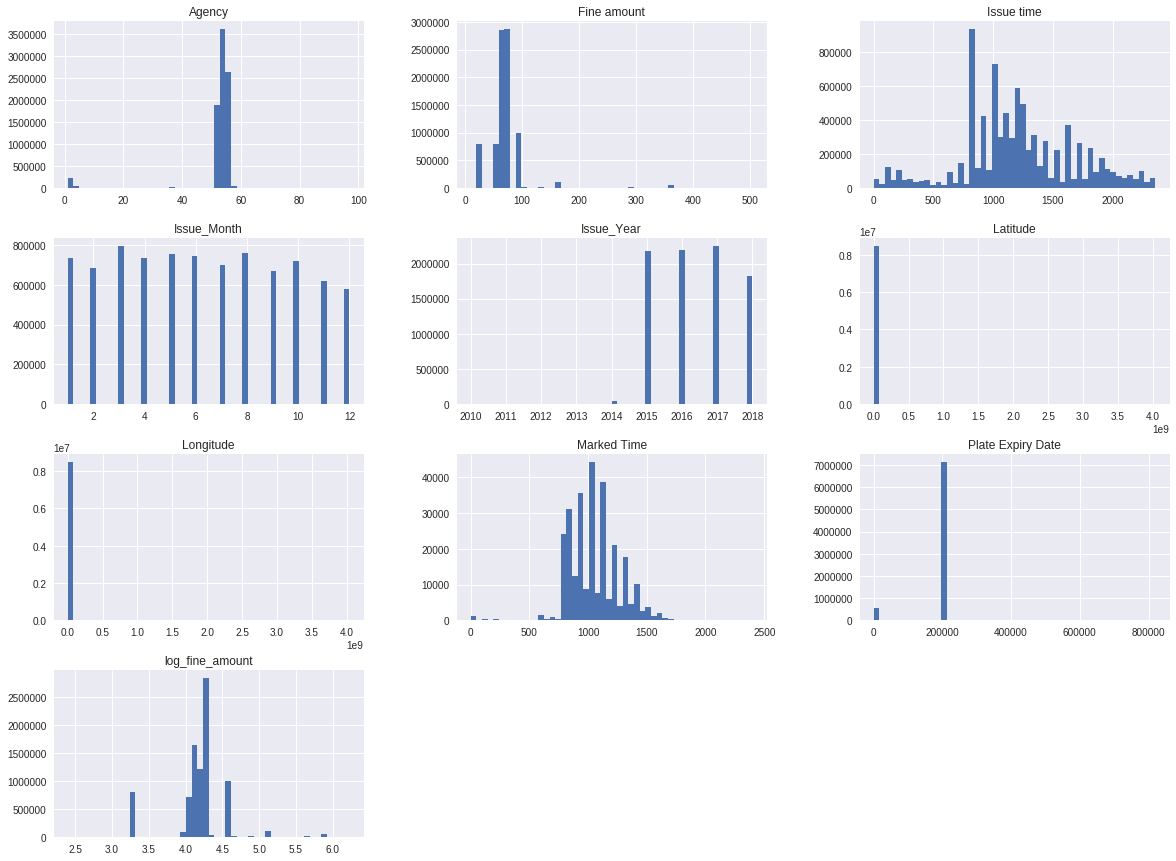

In [0]:
#  Visualize average citation amount
# df_allData["Fine amount"].replace(np.nan, 0)
df_allData['log_fine_amount'] = np.log(df_allData['Fine amount'].values +1)
# plt.hist(df_allData['log_fine_amount'].values, bins=100)
# plt.xlabel('log(Fine amount)')
# plt.ylabel('number of records')
# plt.show

#  Create histograms of data fields
%matplotlib inline
import matplotlib.pyplot as plt
df_allData.hist(bins=50, figsize=(20,15))
plt.show()

#  Prepare Training Data 
Train/Test Split method



1.   Split the dataset into two pieces: a training set and a testing set.
2.   Train the model on the training set.

1.   Test the model on the testing set, and evaluate how well we did.

In [0]:
feature_names = list(df_allData.columns)
print(np.setdiff1d(df_allData.columns, df_allData.columns))
do_not_use_for_training = ['Plate Expiry Date','Latitude', 
                           'Longitude', 'VIN',
                           'Make', 'Body Style', 'Color']
feature_names = [f for f in df_allData.columns if f not in do_not_use_for_training]
# print(feature_names)
print('We have %i features.' % len(feature_names))
df_allData[feature_names].count()

#  Create X (features) and y (response)
#X = df_allData.data
#y = df_allData.target
# STEP 1: split X and y into training and testing sets
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=4)

[]
We have 17 features.
